## Import Statements

In [1]:
# Basic Imports
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# PyTorch Core Modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Image Processing
from torchvision import transforms, datasets
from PIL import Image 

# timm: PyTorch Image Models
import timm

# Grad-CAM for visual explanations of CNN decisions
import cv2
import torch.nn.functional as F

# SHAP for model interpretability
import shap

# LIME for local interpretable model explanations
from lime import lime_image
from skimage.segmentation import mark_boundaries

## Train CNN EfficientNet Model

In [2]:
# Paths to training, validation, and test image directories
TRAIN_DIR = 'real-vs-fake/train'
VAL_DIR   = 'real-vs-fake/valid'
TEST_DIR  = 'real-vs-fake/test'

# Hyperparameters for training
BATCH_SIZE    = 32          # Number of images per training batch
NUM_EPOCHS    = 5           # Total passes through the entire training dataset
LEARNING_RATE = 1e-4        # Step size for the optimizer
IMG_SIZE      = 224         # Image input size expected by EfficientNet-B0

# Automatically use GPU if available; fallback to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [ ]:
# Define data augmentation and normalization for training images
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),         # Resize image to match model input
    transforms.RandomHorizontalFlip(),               # Randomly flip image for data augmentation
    transforms.ToTensor(),                           # Convert image to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406],      # Normalize using ImageNet mean
                         [0.229, 0.224, 0.225])      # and standard deviation
])

# Validation/test transforms : no augmentation, just resizing and normalization
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Load images from directories using the defined transformations
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

# Create data loaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Display class names and their corresponding indices
print("Classes:", train_dataset.classes)

Classes: ['fake', 'real']


In [4]:
# Load a pre-trained EfficientNet-B0 model from timm
model = timm.create_model('efficientnet_b0', pretrained=True)

# Modify the final classifier layer for binary classification (2 output classes)
num_features     = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

# Move the model to GPU or CPU as appropriate
model = model.to(DEVICE)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()                             # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Adam optimizer with specified LR

print(model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [ ]:
# Training utilities
from tqdm import tqdm  # For progress bars

# Train for one epoch
def train_one_epoch(model, train_loader, optimizer, criterion, device=DEVICE):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct      = 0
    total        = 0
    
    # Iterate over training batches
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and accuracy stats
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct      += (predicted == labels).sum().item()
        total        += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

# Validate on the validation set
def validate_one_epoch(model, val_loader, criterion, device=DEVICE):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct      = 0
    total        = 0
    
    # No gradients needed for validation
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss    = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct      += (predicted == labels).sum().item()
            total        += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

# Training loop
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc     = validate_one_epoch(model, val_loader, criterion, DEVICE)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

# Save trained model weights to file
torch.save(model.state_dict(), 'efficientnet_b0_real_vs_fake.pth')
print("Model saved to efficientnet_b0_real_vs_fake.pth")


Epoch [1/5]
Train Loss: 0.0586, Train Acc: 0.9767
Val Loss:   0.0079, Val Acc:   0.9978


Epoch [2/5]
Train Loss: 0.0103, Train Acc: 0.9964
Val Loss:   0.0070, Val Acc:   0.9980


Epoch [3/5]
Train Loss: 0.0065, Train Acc: 0.9978
Val Loss:   0.0049, Val Acc:   0.9986


Epoch [4/5]
Train Loss: 0.0054, Train Acc: 0.9983
Val Loss:   0.0569, Val Acc:   0.9776


Epoch [5/5]
Train Loss: 0.0039, Train Acc: 0.9987
Val Loss:   0.0045, Val Acc:   0.9985
Model saved to efficientnet_b0_real_vs_fake.pth


In [ ]:
# Set model to evaluation mode
model.eval()
test_correct = 0
test_total   = 0

# Disable gradient computation for faster inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs        = model(images)
        _, predicted   = torch.max(outputs, 1)  # Get predicted class with highest logit
        test_correct   += (predicted == labels).sum().item()
        test_total     += labels.size(0)

# Calculate and display test accuracy
test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9776


## Loading the model

In [7]:
def load_model(checkpoint_path):
    # Recreate the model architecture (same as used in training)
    model = timm.create_model('efficientnet_b0', pretrained=False)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, 2)  # Binary classification
    
    # Load saved weights
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()  # Set model to evaluation mode

    print(f"Model loaded from: {checkpoint_path}")
    print("Label mapping: 0 = fake, 1 = real")
    return model

In [8]:
# model = load_model('efficientnet_b0_real_vs_fake.pth')
model = load_model('efficientnet_b0_extra_finetuned.pth')

Model loaded from: efficientnet_b0_extra_finetuned.pth
Label mapping: 0 = fake, 1 = real


## GRAD-CAM Implementation

In [10]:
def grad_cam(model, image_tensor, class_idx=None, device=DEVICE):
    """
    model        : trained model
    image_tensor : single image tensor of shape (1, C, H, W)
    class_idx    : which class to visualize Grad-CAM for. If None, uses predicted class.
    """
    model.eval()
    
    # Identify the last convolutional layer of EfficientNet for Grad-CAM
    target_layer = model.blocks[-1][-1].conv_pw  # last conv layer
    
    # Lists to store outputs captured by hooks
    conv_output = []
    grad_output = []
    
    # Forward hook captures activations
    def forward_hook(module, inp, out):
        conv_output.append(out)
        
    # Backward hook captures gradients of activations
    def backward_hook(module, grad_in, grad_out):
        grad_output.append(grad_out[0])
    
    # Register hooks to the target layer
    forward_handle  = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    
    # Forward pass through model
    output = model(image_tensor.to(device))
    if class_idx is None:
        class_idx = torch.argmax(output, dim=1).item()
    
    # Backward pass w.r.t. chosen class logit
    model.zero_grad()
    loss = output[0, class_idx]
    loss.backward()
    
    # Extract stored activations and gradients
    activations = conv_output[0].detach().cpu().numpy()[0, :]
    gradients   = grad_output[0].detach().cpu().numpy()[0, :]
    
    # Global average pooling of gradients to get weights for channels
    weights = np.mean(gradients, axis=(1, 2))
    
    # Compute Grad-CAM as a weighted sum of channels
    cam = np.zeros(activations.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations[i, :, :]
    
    # Apply ReLU to keep only positive influences
    cam = np.maximum(cam, 0)
    # Normalize CAM to [0, 1]
    cam -= np.min(cam)
    cam /= np.max(cam) if np.max(cam) != 0 else 1
    
    # Clean up: remove hooks
    forward_handle.remove()
    backward_handle.remove()
    
    return cam, class_idx

def show_grad_cam_on_image(img_pil, cam):
    """
    Overlays the Grad-CAM heatmap on the original image
    """
    img     = np.array(img_pil)
    h, w, _ = img.shape
    cam = cv2.resize(cam, (w, h))  # Resize heatmap to match image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay_img = heatmap + np.float32(img) / 255  # Blend with original
    overlay_img = overlay_img / np.max(overlay_img)
    return np.uint8(255 * overlay_img)

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class index: 0
Predicted label: fake


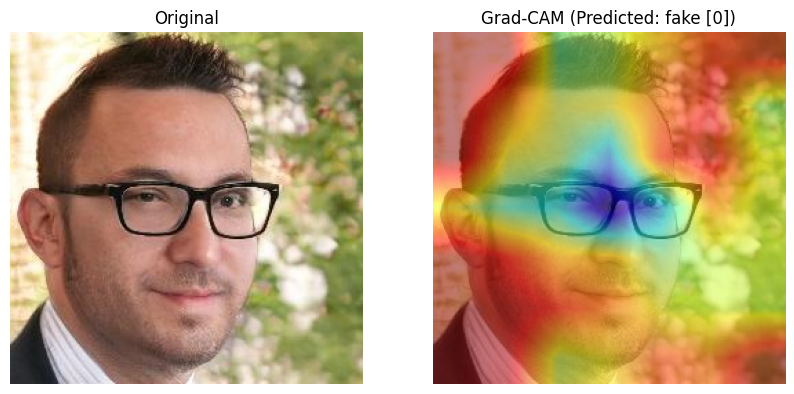

In [11]:
# Manually specify the image path to test Grad-CAM on
img_path = "fake_test.jpg"
example_img_pil = Image.open(img_path).convert('RGB')  # Ensure 3-channel RGB image

# Apply validation transforms and add batch dimension
transform = val_transforms
example_img_tensor = transform(example_img_pil).unsqueeze(0).to(DEVICE)  # shape: (1, C, H, W)

# Run Grad-CAM to get heatmap and predicted class
cam, predicted_class = grad_cam(model, example_img_tensor)

# Map predicted class index to label name
predicted_label = train_dataset.classes[predicted_class]

# Print prediction results
print(f"Predicted class index: {predicted_class}")
print(f"Predicted label: {predicted_label}")

# Generate and save Grad-CAM heatmap overlaid on the original image
grad_cam_result = show_grad_cam_on_image(example_img_pil, cam)
Image.fromarray(grad_cam_result).save("grad_cam_output.jpg")

# Plot original and Grad-CAM result side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(example_img_pil)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM (Predicted: {predicted_label} [{predicted_class}])")
plt.imshow(grad_cam_result)
plt.axis('off')

plt.show()

## Binary Mask - To extract important regions

In [13]:
def xai_to_binary_mask(cam, threshold=0.5):
    """
    Converts a normalized Grad-CAM output (cam) into a binary mask.

    Args:
        cam: A 2D numpy array of normalized Grad-CAM values (range 0 to 1).
        threshold: A float between 0 and 1 that defines which pixels are deemed 'important'.
                   Pixels with values >= threshold are marked as important.
    
    Returns:
        A binary mask image as a 2D numpy array with values 0 (non-important) and 255 (important).
    """
    # Create the binary mask: pixels with activation >= threshold become 1, else 0
    binary_mask = (cam >= threshold).astype(np.uint8)
    
    # Multiply by 255 to scale up to a typical image format (8-bit)
    binary_mask *= 255

    return binary_mask

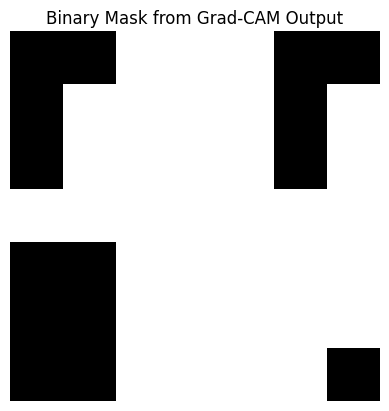

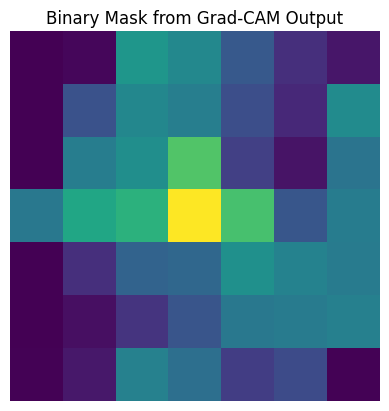

In [14]:
# Manually specify the image path
img_path = "fake_test.jpg"
example_img_pil = Image.open(img_path).convert('RGB')

# Apply the same validation transform
transform = val_transforms
example_img_tensor = transform(example_img_pil).unsqueeze(0).to(DEVICE)  # shape: (1, C, H, W)

# Run Grad-CAM
cam, predicted_class = grad_cam(model, example_img_tensor)

# Define the threshold (value between 0 and 1)
threshold = 0.15 # Adjust this value as per your requirement

# Obtain the binary mask
binary_mask = xai_to_binary_mask(cam, threshold)

plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask from Grad-CAM Output")
plt.axis('off')
plt.show()

plt.imshow(cam)
plt.title("Binary Mask from Grad-CAM Output")
plt.axis('off')
plt.show()


## SHAP Implementation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


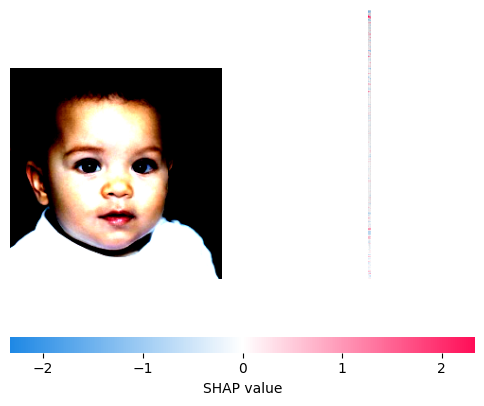

In [ ]:
# Create a small batch of training images as background reference for SHAP
background_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
background_images, _ = next(iter(background_loader))
background_images = background_images.to(DEVICE)

# Initialize SHAP GradientExplainer with model and background data
explainer = shap.GradientExplainer(model, background_images)

# Pick a single image from validation set for explanation
val_sample, val_label = val_dataset[0]
shap_input = val_sample.unsqueeze(0).to(DEVICE)  # Add batch dimension

# Compute SHAP values for all output classes
shap_values = explainer.shap_values(shap_input)

# Rearrange SHAP outputs to shape (1, H, W, C) for visualization
shap_values = [s.transpose(0, 2, 3, 1) for s in shap_values]

# Predict the class to visualize corresponding SHAP explanation
pred = model(shap_input).argmax(dim=1).item()

# Prepare input image in shape (1, H, W, C) for SHAP visualization
pixel_values = np.array([np.array(val_sample.permute(1, 2, 0))])

# Visualize SHAP explanation for predicted class
shap.image_plot([shap_values[pred]], pixel_values)


## LIME Implementation

  0%|          | 0/1000 [00:00<?, ?it/s]

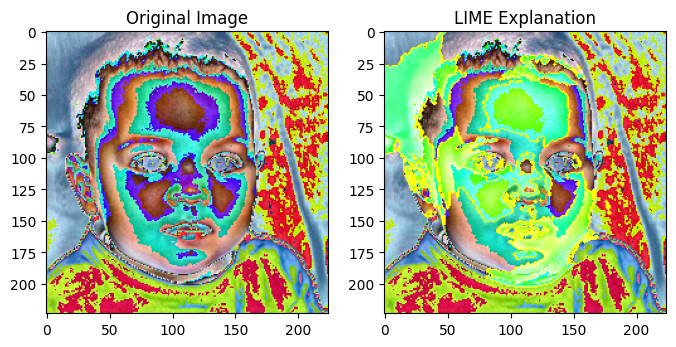

In [ ]:
# Initialize LIME image explainer
lime_explainer = lime_image.LimeImageExplainer()

def lime_predict(images):
    """
    Converts raw RGB images (0..255) to model-ready tensors and returns predicted probabilities.
    Required format for LIME: list of numpy arrays → probabilities for each class.
    """
    model.eval()
    batch = []
    for img in images:
        # Convert from NumPy [H, W, C] to PIL, then to normalized tensor
        pil_img = Image.fromarray(np.uint8(img))
        t = val_transforms(pil_img)
        batch.append(t)
    
    batch = torch.stack(batch).to(DEVICE)
    with torch.no_grad():
        outputs = model(batch)
        probs = F.softmax(outputs, dim=1).cpu().numpy()  # Return probability for each class
    return probs

# Convert validation image to uint8 NumPy format for LIME
val_img_arr = np.array(val_sample.permute(1, 2, 0).cpu() * 255, dtype=np.uint8)

# Run LIME explanation on a single image
explanation = lime_explainer.explain_instance(
    val_img_arr,
    lime_predict,
    top_labels=2,        # Request explanations for top 2 predicted classes
    hide_color=0,        # Color to replace hidden regions with
    num_samples=1000     # Number of perturbed samples to generate
)

# Select the predicted label to visualize explanation
lime_pred_label = model(val_sample.unsqueeze(0).to(DEVICE)).argmax(dim=1).item()

# Get explanation mask and highlighted image
lime_temp, lime_mask = explanation.get_image_and_mask(
    label=lime_pred_label,
    positive_only=False,
    hide_rest=False,
    num_features=5,      # Show top 5 contributing regions
    min_weight=0.0
)

# Plot original image and LIME result side-by-side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(val_img_arr)

plt.subplot(1, 2, 2)
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(lime_temp, lime_mask))
plt.show()

## Output Generation

In [12]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Directories to save outputs
output_dir = Path("explanations")
gradcam_dir = output_dir / "gradcam"
lime_dir = output_dir / "lime"
(gradcam_dir / "real").mkdir(parents=True, exist_ok=True)
(gradcam_dir / "fake").mkdir(parents=True, exist_ok=True)
(lime_dir / "real").mkdir(parents=True, exist_ok=True)
(lime_dir / "fake").mkdir(parents=True, exist_ok=True)
(output_dir / "real").mkdir(parents=True, exist_ok=True)
(output_dir / "fake").mkdir(parents=True, exist_ok=True)

# Collect 5 real and 5 fake images from test dataset
real_images = []
fake_images = []

for path, label in test_dataset.samples:
    if label == 0 and len(real_images) < 5:
        real_images.append((path, label))
    elif label == 1 and len(fake_images) < 5:
        fake_images.append((path, label))
    if len(real_images) == 5 and len(fake_images) == 5:
        break

selected_images = real_images + fake_images

# Process each image
for idx, (img_path, label) in enumerate(selected_images):
    label_name = "real" if label == 0 else "fake"
    pil_img = Image.open(img_path).convert("RGB")

    # Save original image
    original_output_path = output_dir / label_name / f"img_{idx}_{label_name}_original.jpg"
    original_output_path.parent.mkdir(parents=True, exist_ok=True)
    pil_img.save(original_output_path)

    img_tensor = val_transforms(pil_img).unsqueeze(0).to(DEVICE)

    ### GRAD-CAM
    cam, pred_class = grad_cam(model, img_tensor)
    cam_overlay = show_grad_cam_on_image(pil_img, cam)
    cam_output_path = gradcam_dir / label_name / f"img_{idx}_{label_name}_gradcam.jpg"
    Image.fromarray(cam_overlay).save(cam_output_path)

    ### LIME
    img_arr = np.array(pil_img)
    explanation = lime_explainer.explain_instance(
        img_arr,
        lime_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )
    lime_pred = model(img_tensor).argmax(dim=1).item()
    lime_img, lime_mask = explanation.get_image_and_mask(
        label=lime_pred,
        positive_only=False,
        hide_rest=False,
        num_features=5,
        min_weight=0.0
    )
    lime_output = mark_boundaries(lime_img, lime_mask)
    lime_output_path = lime_dir / label_name / f"img_{idx}_{label_name}_lime.jpg"
    plt.imsave(lime_output_path, lime_output)

print("Saved original, Grad-CAM, and LIME outputs for 10 images.")


c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved original, Grad-CAM, and LIME outputs for 10 images.
